In [1]:
import cymetric as cym
import glob
from cymetric import graphs
import pandas


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.enrichment is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
import sys
import argparse
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib import colors, ticker
import random

from pyDOE import lhs
import numpy as np
import pandas as pd
from scipy import stats, integrate
import seaborn as sns
%matplotlib inline

In [3]:
from cymetric import timeseries as tm

In [4]:
nuc_list_in = ["238pu", "239pu", "240pu", "241pu", "242pu", "241am"]
nuc_list_out = ["out_238pu", "out_239pu", "out_240pu", "out_241pu", "out_242pu", "out_241am"]


def get_ev(file):
    db = cym.dbopen(file)
    ev = cym.Evaluator(db)
    return ev


In [5]:
# Merthod to get all Cycle Fractions

def get_nuc_frac_boc(ev, nuc):
    df = tm.transactions(ev, receivers=['lwr'], nucs=[nuc] )
    df = df[df['Mass'] > 0 ]

    tot = tm.transactions(ev, receivers=['lwr'], nucs=nuc_list_in) 
    tot = tot[tot['Mass'] > 0 ]                

    df['Mass'] = df['Mass']/tot['Mass']
    return df.iloc[2]['Mass']

def get_pu_frac_boc(ev):
    df = tm.transactions(ev, receivers=['lwr'], nucs=nuc_list_in )
    df = df[df['Mass'] > 0 ]

    tot = tm.transactions(ev, receivers=['lwr']) 
    tot = tot[tot['Mass'] > 0 ]                

    df['Mass'] = df['Mass']/tot['Mass']
    return df.iloc[2]['Mass']

def get_nuc_frac_eoc(ev, nuc):
    df = tm.transactions(ev, senders=['lwr'], nucs=[nuc] )
    df = df[df['Mass'] > 0 ]

    tot = tm.transactions(ev, senders=['lwr'], nucs=nuc_list_in) 
    tot = tot[tot['Mass'] > 0 ]                

    df['Mass'] = df['Mass']/tot['Mass']
    return df.iloc[2]['Mass']

def eoc_pu_compo(ev):
    compo = []
    for nuc in nuc_list_in:
        compo.append(get_nuc_frac_eoc(ev, nuc))
    return compo

def boc_pu_compo(ev):
    compo = []
    for nuc in nuc_list_in:
        compo.append(get_nuc_frac_boc(ev, nuc))
    return compo

def get_pu_frac_eoc(ev):
    df = tm.transactions(ev, senders=['lwr'], nucs=nuc_list_in )
    df = df[df['Mass'] > 0 ]

    tot = tm.transactions(ev, senders=['lwr']) 
    tot = tot[tot['Mass'] > 0 ]                

    df['Mass'] = df['Mass']/tot['Mass']
    return df.iloc[2]['Mass']

In [6]:
# Get all Fractions

def get_intel(ev):
    tt = boc_pu_compo(ev) + eoc_pu_compo(ev) +  [get_pu_frac_boc(ev)] + [get_pu_frac_eoc(ev)]
    return tt

In [7]:
def pairgrid_heatmap(x, y, **kws):
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    plt.tricontour(x, y, df_frac, 100, levels=np.linspace(0.03,0.15,100), cmap="viridis", vmin=0.03, vmax=0.15, zorder=0, **kws)


def plot(df, filename,name_matrix):
    g = sns.PairGrid(df, vars=("238pu", "239pu", "240pu", "241pu", "242pu", "241am"))
    g.map_diag(sns.kdeplot)
    cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
    #g.map_upper(sns.kdeplot, cmap=cmap, n_levels=60, shade=True);
    g.map_upper(plt.scatter);


    g.map_lower(pairgrid_heatmap);
    cax = g.fig.add_axes([-.1, .1, .03, .8])
    #plt.colorbar(cax=cax)
    
    norm= matplotlib.colors.Normalize(vmin=df_frac.min(), vmax=df_frac.max())
    # a previous version of this used
    #norm= matplotlib.colors.Normalize(vmin=cs.vmin, vmax=cs.vmax)
    # which does not work any more
    sm = plt.cm.ScalarMappable(norm=norm)
    sm.set_array([])
    plt.colorbar(sm, cax=cax)
    
    print(df_frac.min(), df_frac.max())
    
    

    g.savefig(filename)

In [8]:
def plot_distrib(df, filename,name_matrix):
    g = sns.PairGrid(df, vars=("238pu", "239pu", "240pu", "241pu", "242pu", "241am"))
    g.map_diag(sns.kdeplot)
    cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
    g.map_upper(plt.scatter);
 
    #g.map_lower(pairgrid_heatmap);
    #cax = g.fig.add_axes([-.04, .1, .03, .8])
    #plt.colorbar(cax=cax)

    g.savefig(filename)

In [9]:
def get_fraction(files):
    data =[]
    for i, file in enumerate(sorted(glob.glob(files))):
        if i%10 == 0:
            print(i, file)
        ev = get_ev(file)
        data.append(get_intel(ev))
        
    return data

In [145]:
data_fix = get_fraction("*_fix.h5")
data_pueq = get_fraction("*_pueq.h5")

0 0_fix.h5
10 109_fix.h5
20 118_fix.h5
30 127_fix.h5
40 136_fix.h5
50 145_fix.h5
60 154_fix.h5
70 163_fix.h5
80 172_fix.h5
90 181_fix.h5
100 190_fix.h5
110 19_fix.h5
120 208_fix.h5
130 217_fix.h5
140 226_fix.h5
150 235_fix.h5
160 244_fix.h5
170 253_fix.h5
180 262_fix.h5
190 271_fix.h5
200 280_fix.h5
210 28_fix.h5
220 299_fix.h5
230 307_fix.h5
240 316_fix.h5
250 325_fix.h5
260 334_fix.h5
270 343_fix.h5
280 352_fix.h5
290 361_fix.h5
300 370_fix.h5
310 37_fix.h5
320 389_fix.h5
330 398_fix.h5
340 406_fix.h5
350 415_fix.h5
360 424_fix.h5
370 433_fix.h5
380 442_fix.h5
390 451_fix.h5
400 460_fix.h5
410 46_fix.h5
420 479_fix.h5
430 488_fix.h5
440 497_fix.h5
450 505_fix.h5
460 514_fix.h5
470 523_fix.h5
480 532_fix.h5
490 541_fix.h5
500 550_fix.h5
510 55_fix.h5
520 569_fix.h5
530 578_fix.h5
540 587_fix.h5
550 596_fix.h5
560 604_fix.h5
570 613_fix.h5
580 622_fix.h5
590 631_fix.h5
600 640_fix.h5
610 64_fix.h5
620 659_fix.h5
630 668_fix.h5
640 677_fix.h5
650 686_fix.h5
660 695_fix.h5
670 703_fix.h5

In [26]:
print("toto")

toto


In [10]:
df_fix = pandas.DataFrame(data_fix)
name = nuc_list_in + nuc_list_out + ['Frac_BOC']+ ['Frac_EOC']
df_fix.columns = name

df_eq = pandas.DataFrame(data_pueq)
name = nuc_list_in + nuc_list_out + ['Frac_BOC']+ ['Frac_EOC']
df_eq.columns = name

NameError: name 'data_fix' is not defined

In [13]:
df_fix = pandas.DataFrame()
df_fix.to_csv("fix.csv")
df_eq = pandas.DataFrame()
df_eq.to_csv("eq.csv")

In [14]:
df_fix = pd.DataFrame.from_csv("fix.cvs")
df_eq = pd.DataFrame.from_csv("eq.cvs")

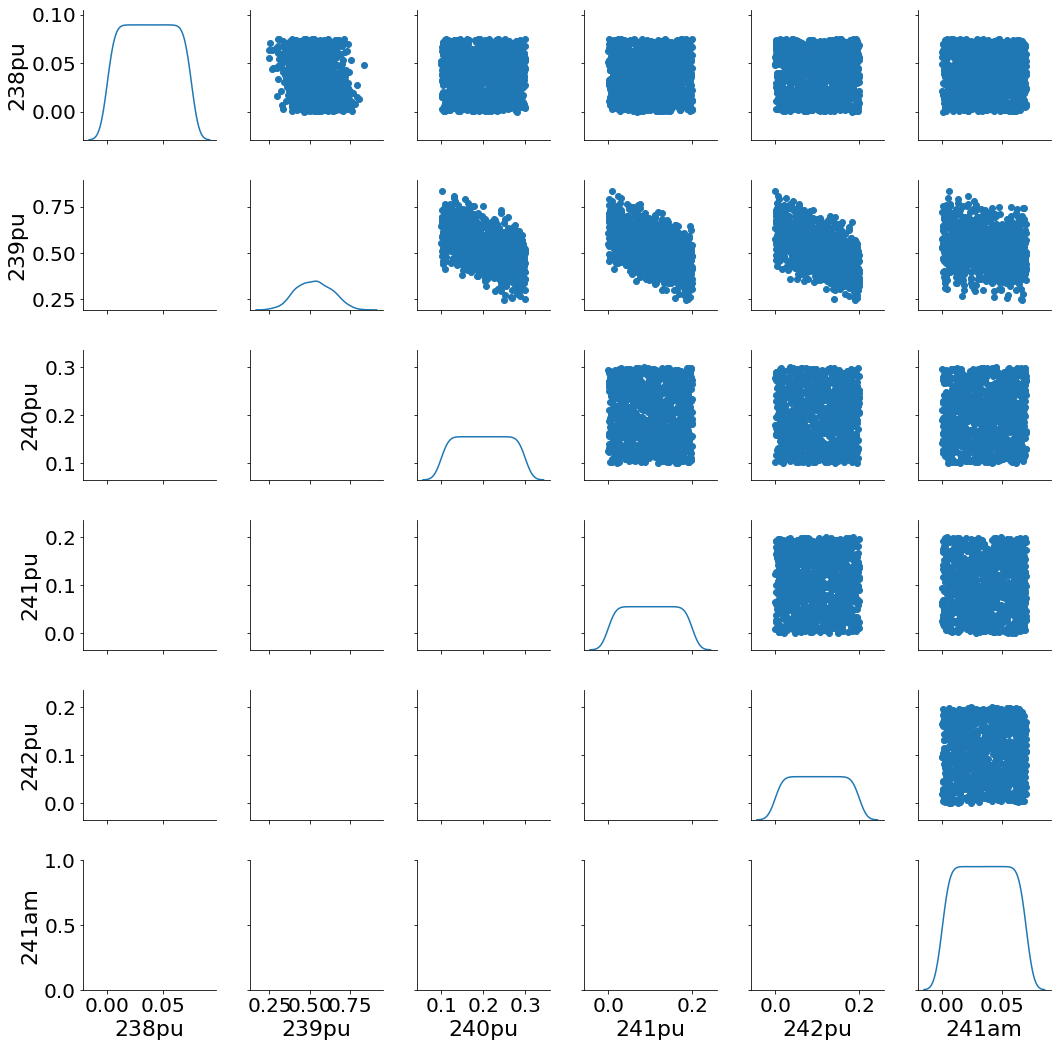

In [15]:
SMALL_SIZE = 20
MEDIUM_SIZE = SMALL_SIZE+2
BIGGER_SIZE = MEDIUM_SIZE +2

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

df_frac = df_fix['Frac_BOC']
plot_distrib(df_fix, "distrib.png", nuc_list_in)


0.07806999999999996 0.07807000000000004


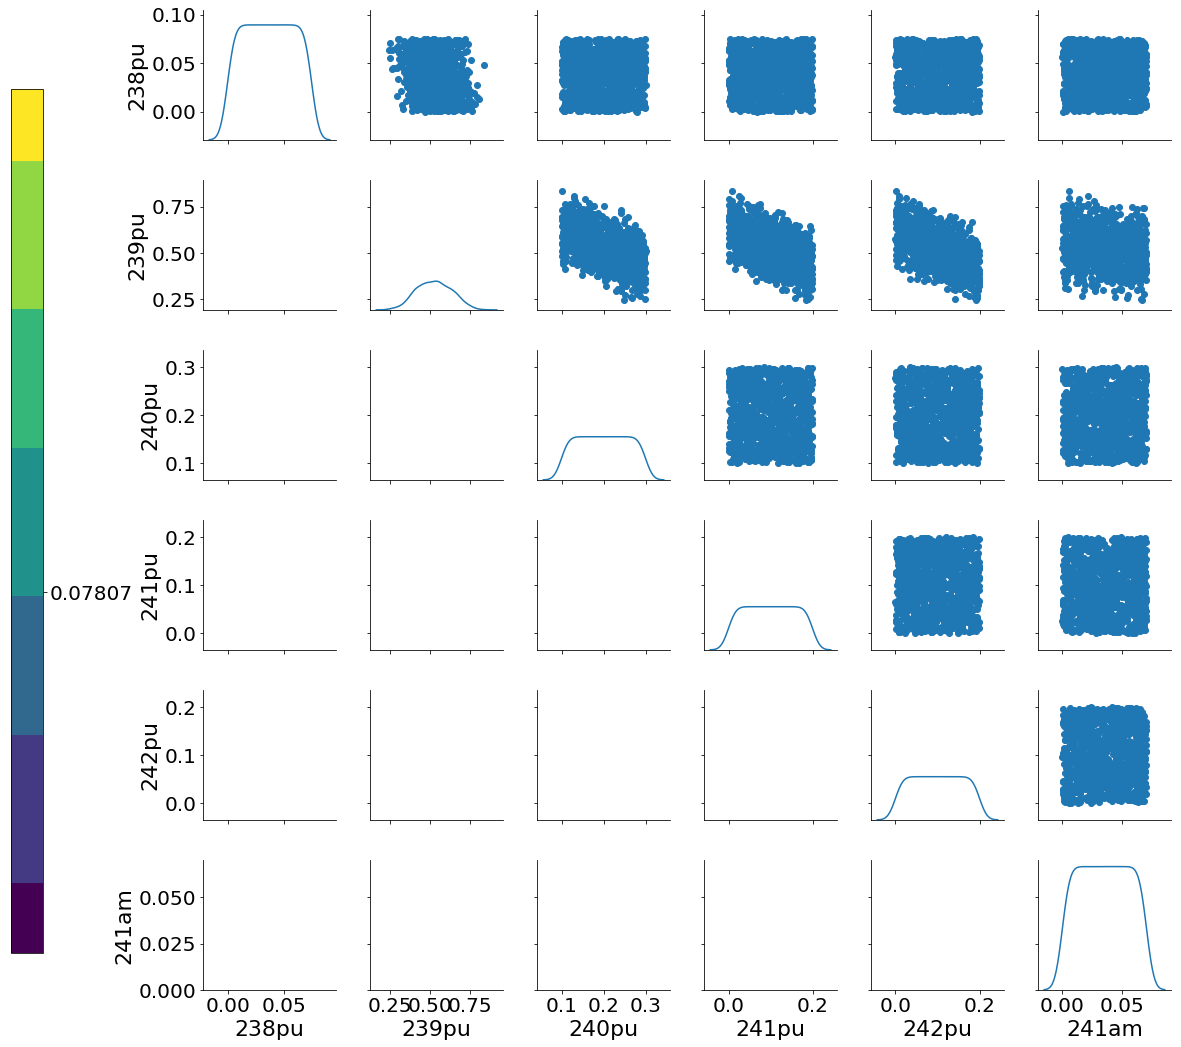

In [16]:
df_frac = df_fix['Frac_BOC']
plot(df_fix, "test.png", nuc_list_in)

0.050616877061560456 0.14454616288545133


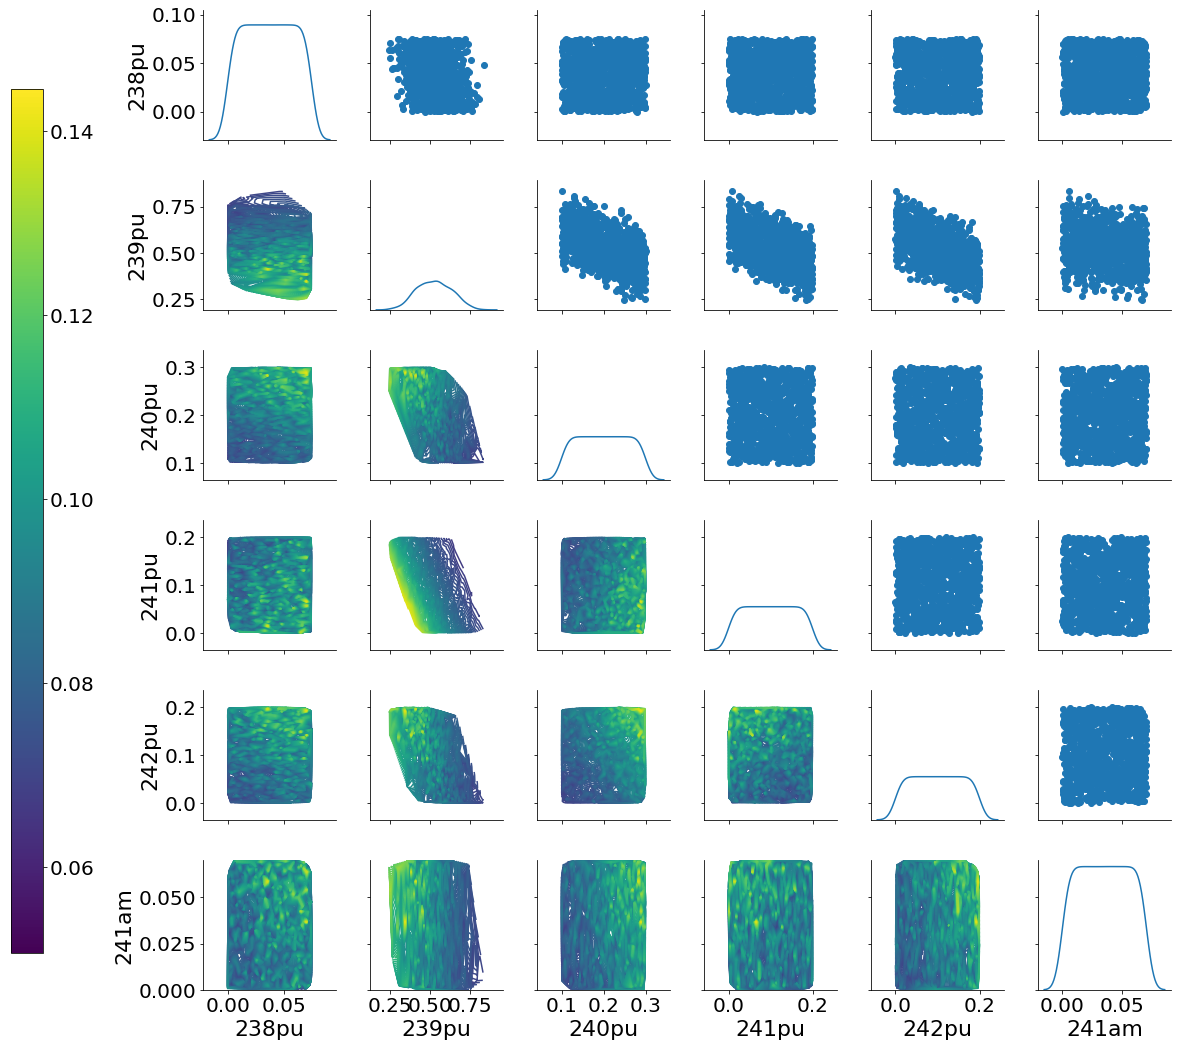

In [18]:
df_frac = df_eq['Frac_BOC']
plot(df_eq, "pu_frac.png", nuc_list_in)


In [20]:
df = df_fix.copy()
df['238pu'] = df_eq['238pu']
df['239pu'] = df_eq['239pu']
df['240pu'] = df_eq['240pu']
df['241pu'] = df_eq['241pu']
df['242pu'] = df_eq['242pu']
df['241am'] = df_eq['241am']
df = df.rename(index=str, columns={"Frac_BOC": "fix_Frac_BOC", "Frac_EOC": "fix_Frac_EOC"})
df = pd.merge(df_eq, df, on=nuc_list_in)
df = df.rename(index=str, columns={"Frac_BOC": "eq_Frac_BOC", "Frac_EOC": "eq_Frac_EOC"})


#df.drop(base_col[1], 1)


In [21]:
df

,238pu,239pu,240pu,241pu,242pu,241am,eq_Frac_BOC,eq_Frac_EOC,fix_Frac_BOC,fix_Frac_EOC
0,0.005726,0.521715,0.292817,0.131138,0.013695,0.034909,0.072617,0.056197,0.07807,0.060996
1,0.028566,0.559127,0.230929,0.068285,0.100144,0.012950,0.076741,0.059141,0.07807,0.060307
2,0.030147,0.543210,0.184449,0.155692,0.069407,0.017096,0.064189,0.047635,0.07807,0.059598
3,0.004548,0.563214,0.130511,0.132413,0.118487,0.050828,0.064512,0.047296,0.07807,0.058948
4,0.037347,0.693098,0.113977,0.029201,0.082391,0.043985,0.066188,0.049276,0.07807,0.059570
5,0.021114,0.613028,0.189564,0.020918,0.114406,0.040969,0.078215,0.060277,0.07807,0.060149
6,0.030477,0.339081,0.288200,0.186175,0.131683,0.024384,0.089964,0.071144,0.07807,0.060627
7,0.029063,0.438808,0.280679,0.072923,0.142228,0.036299,0.101867,0.082348,0.07807,0.061148
8,0.047138,0.435887,0.213402,0.083479,0.171791,0.048302,0.098942,0.079168,0.07807,0.060745
9,0.030433,0.371034,0.293640,0.076705,0.189242,0.038947,0.121365,0.100471,0.07807,0.061587


In [22]:
df['obs1'] =  (df['eq_Frac_BOC'] - df['fix_Frac_BOC'])/df['fix_Frac_BOC']
df['obs1'].max()

0.8514943369469883

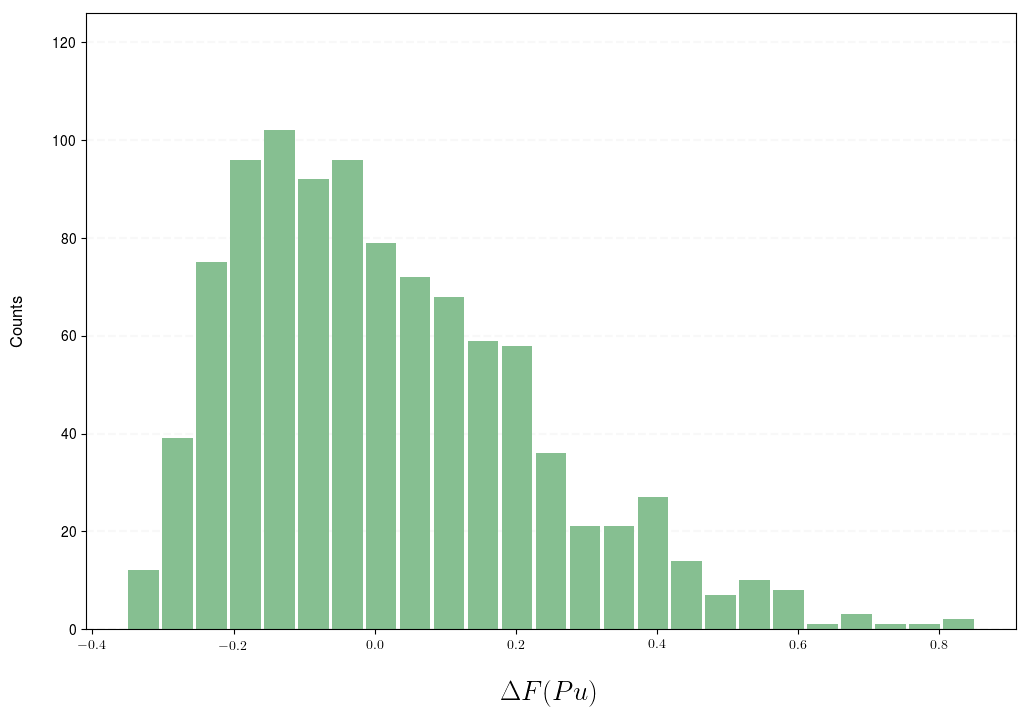

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from matplotlib.ticker import StrMethodFormatter
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
ax = df.hist(column='obs1', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    #x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel(r"$\Delta F(Pu)$", labelpad=20, weight='bold', size=20)

    # Set y-axis label
    x.set_ylabel("Counts", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
plt.savefig("estimator_1.png")

In [24]:
df['obs2'] =  ((df['eq_Frac_BOC'] - df['eq_Frac_EOC'])/df['eq_Frac_BOC'] - (df['fix_Frac_BOC'] - df['fix_Frac_EOC'])/df['fix_Frac_BOC'])/((df['fix_Frac_BOC'] - df['fix_Frac_EOC'])/df['fix_Frac_BOC'])

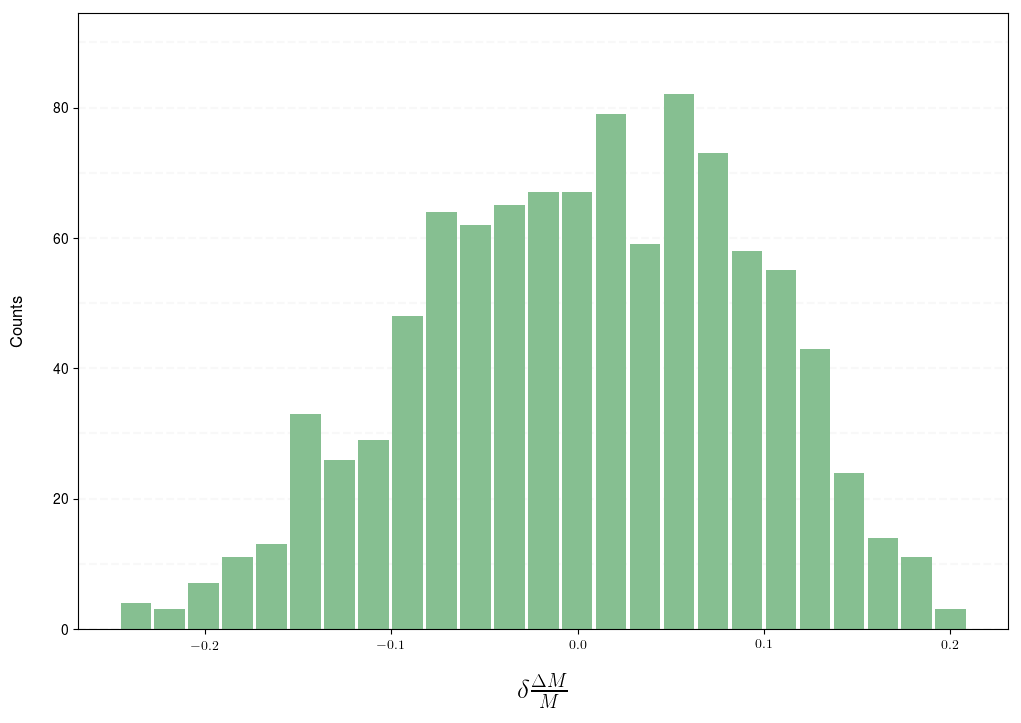

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from matplotlib.ticker import StrMethodFormatter
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
ax = df.hist(column='obs2', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    #x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel(r"$\delta\frac{\Delta M}{M}$", labelpad=20, weight='bold', size=20)

    # Set y-axis label
    x.set_ylabel("Counts", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
plt.savefig("estimator_2.png")

In [26]:
df['obs3'] =  ( (df['eq_Frac_BOC'] - df['eq_Frac_EOC']) - (df['fix_Frac_BOC'] - df['fix_Frac_EOC']) ) / (df['fix_Frac_BOC'] - df['fix_Frac_EOC'])

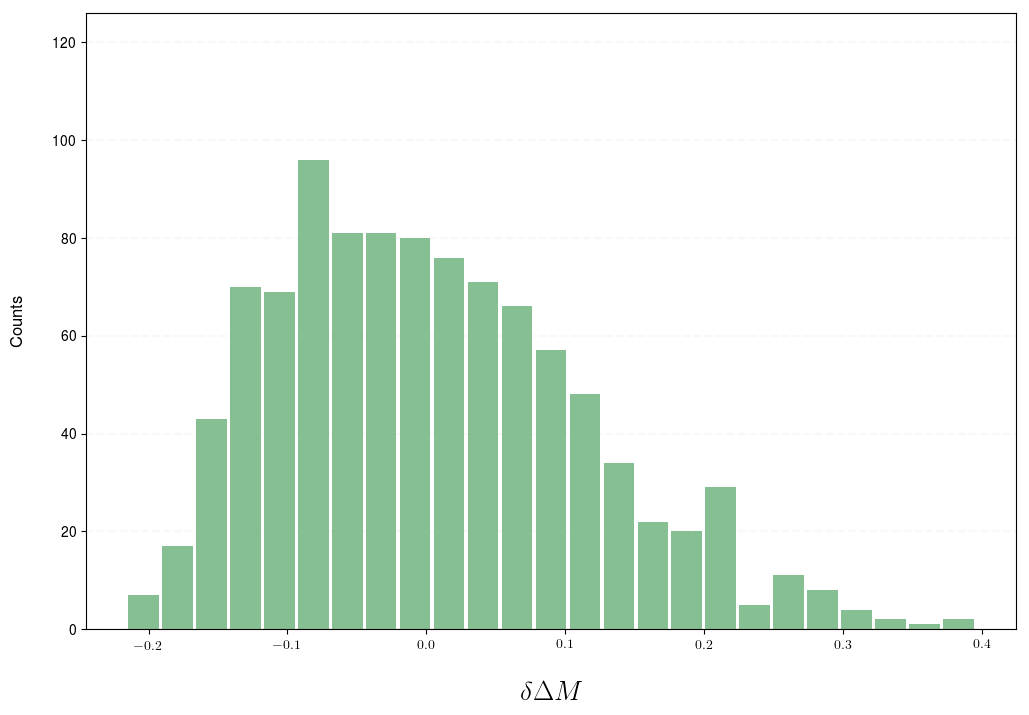

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from matplotlib.ticker import StrMethodFormatter
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
ax = df.hist(column='obs3', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    #x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel(r"$\delta\Delta M$", labelpad=20, weight='bold', size=20)

    # Set y-axis label
    x.set_ylabel("Counts", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
plt.savefig("estimator_3.png")

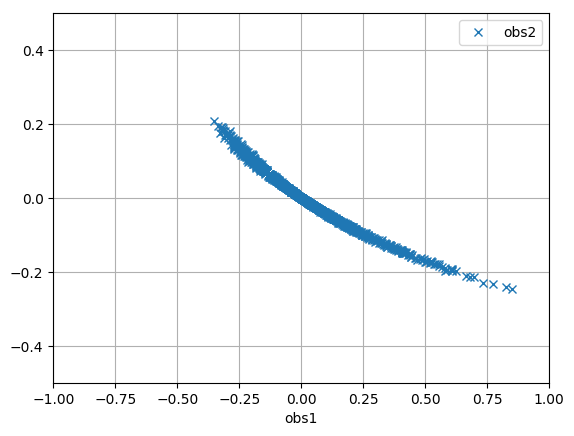

In [28]:
plt.rcParams.update(plt.rcParamsDefault)
df.plot(x='obs1', y='obs2', linestyle='', marker='x')
plt.ylim(-.5, 0.5)
plt.xlim(-1, 1)
plt.grid()

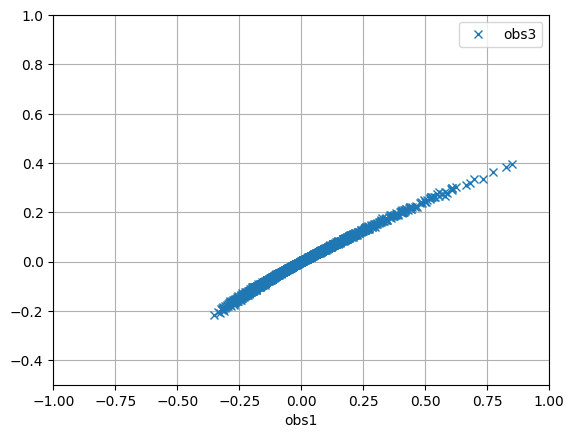

In [29]:
plt.rcParams.update(plt.rcParamsDefault)
df.plot(x='obs1', y='obs3', linestyle='', marker='x')
plt.ylim(-.5, 1)
plt.xlim(-1, 1)
plt.grid()

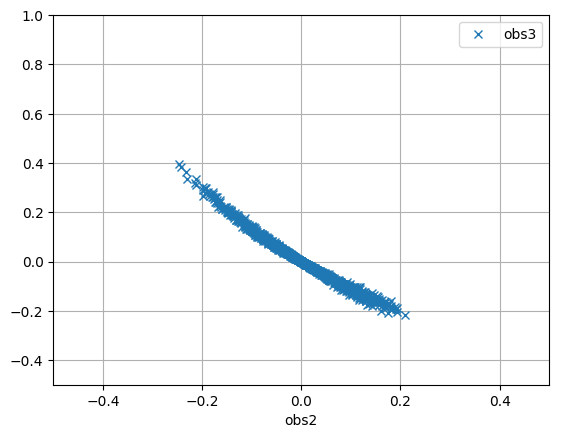

In [30]:
plt.rcParams.update(plt.rcParamsDefault)
df.plot(x='obs2', y='obs3', linestyle='', marker='x')
plt.ylim(-0.5, 1)
plt.xlim(-.5, 0.5)
plt.grid()

-0.35164753347559297 0.8514943369469883


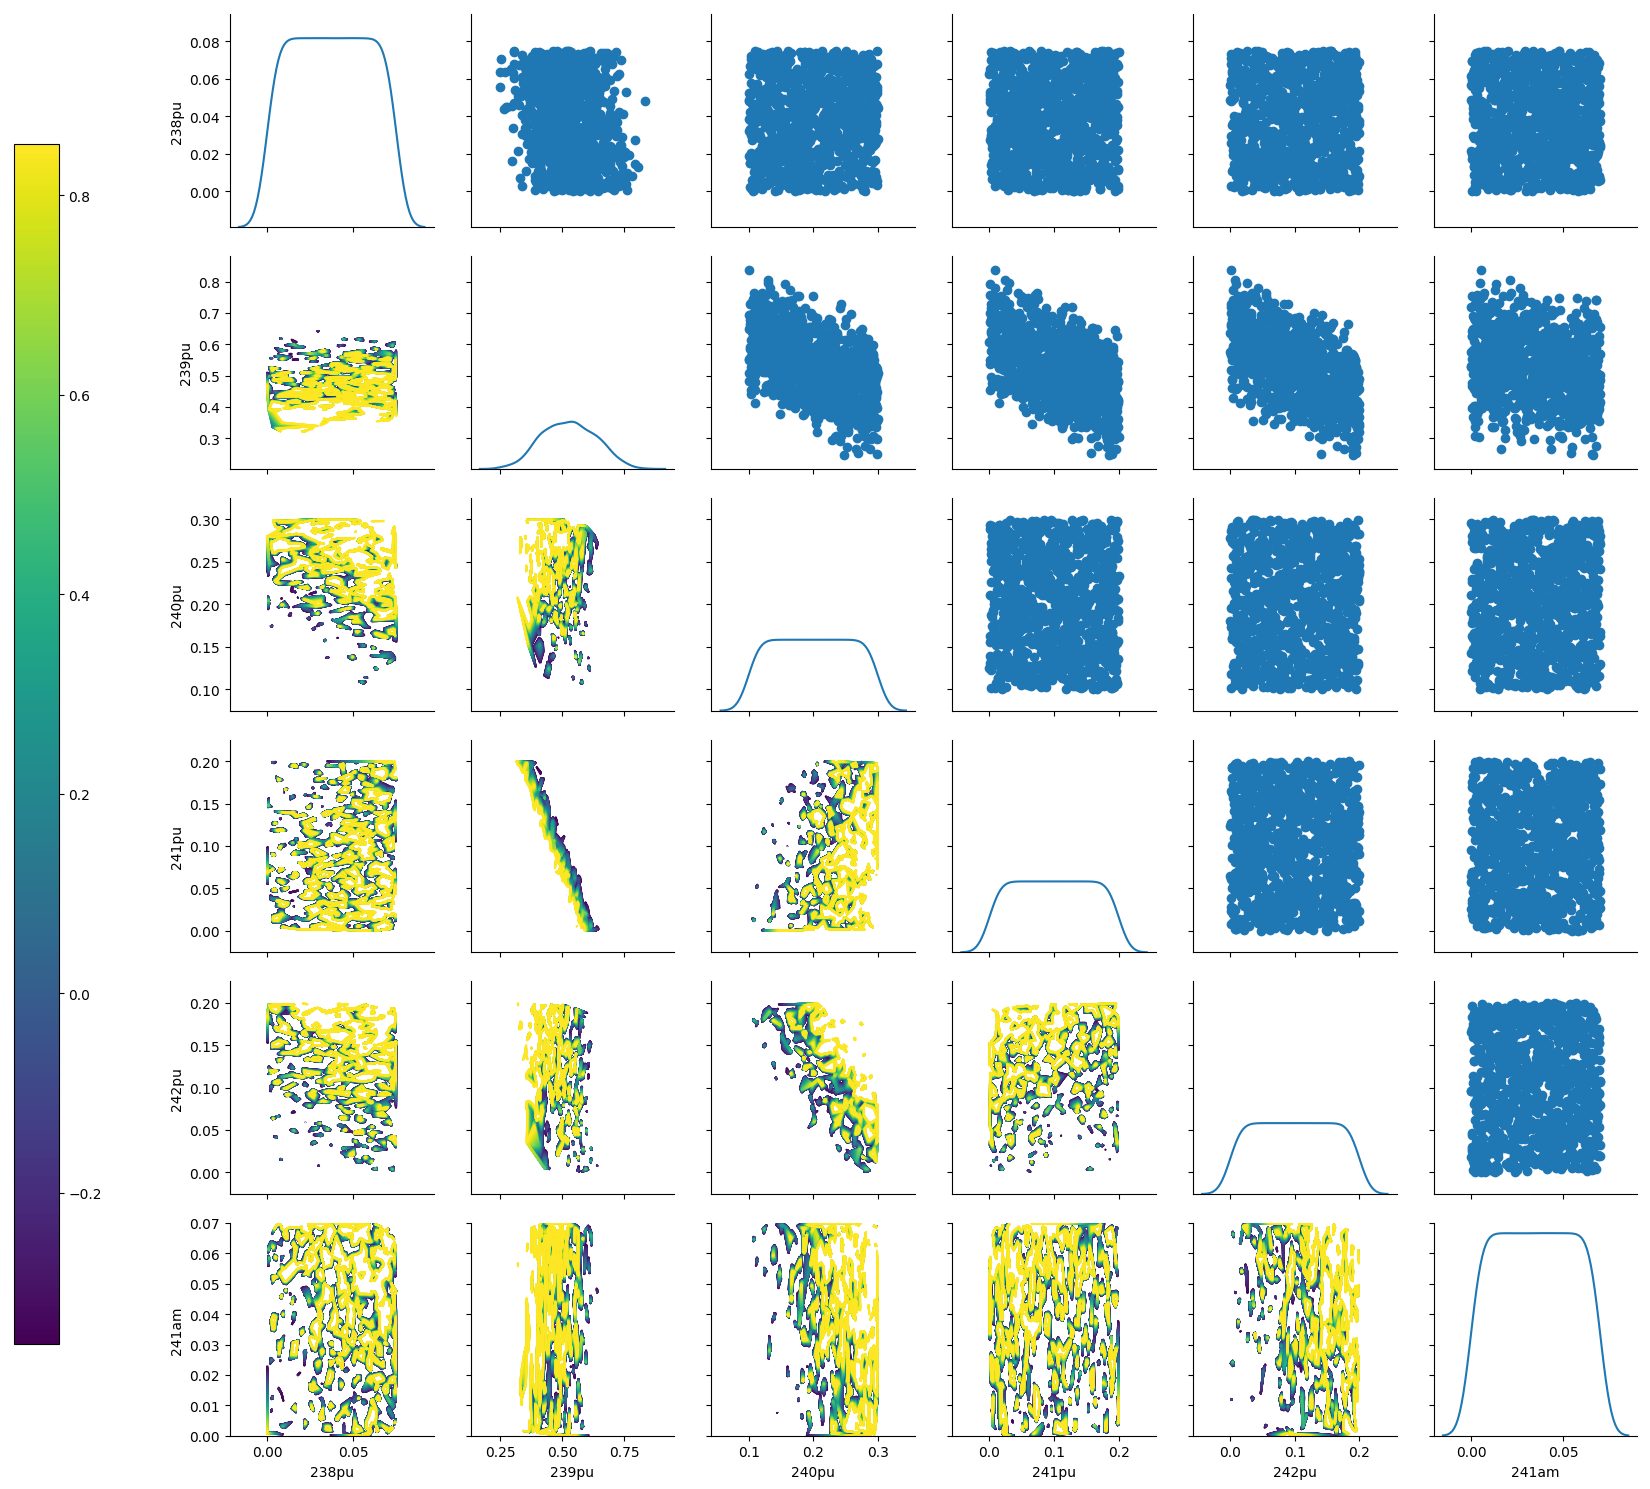

In [31]:
df_frac = df['obs1']
plot(df, "obs1.png", nuc_list_in)

-0.24630520325522448 0.20936516738129704


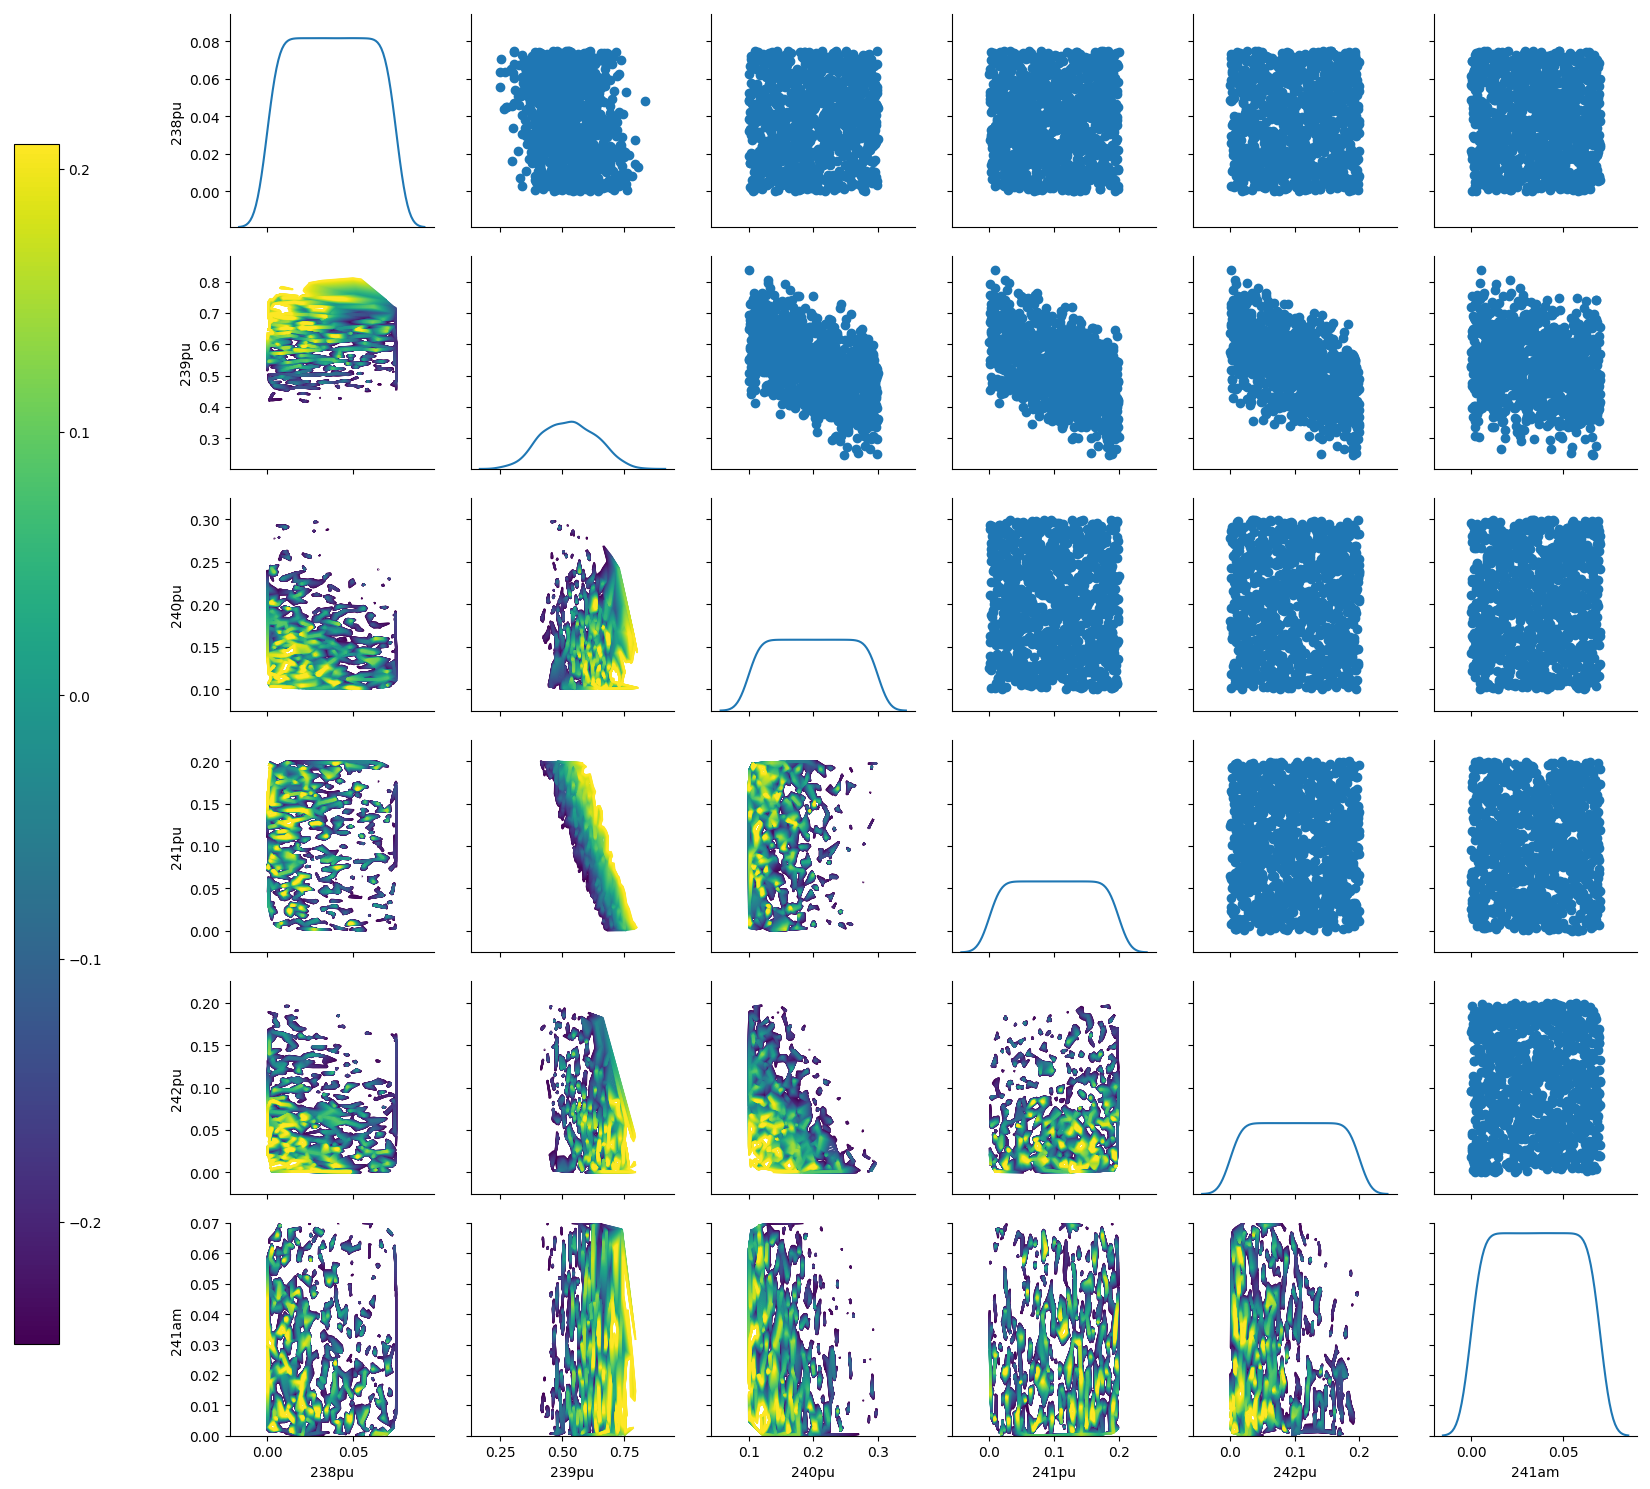

In [32]:
df_frac = df['obs2']
plot(df, "obs2.png", nuc_list_in)

-0.21590511079963373 0.3954616479593632


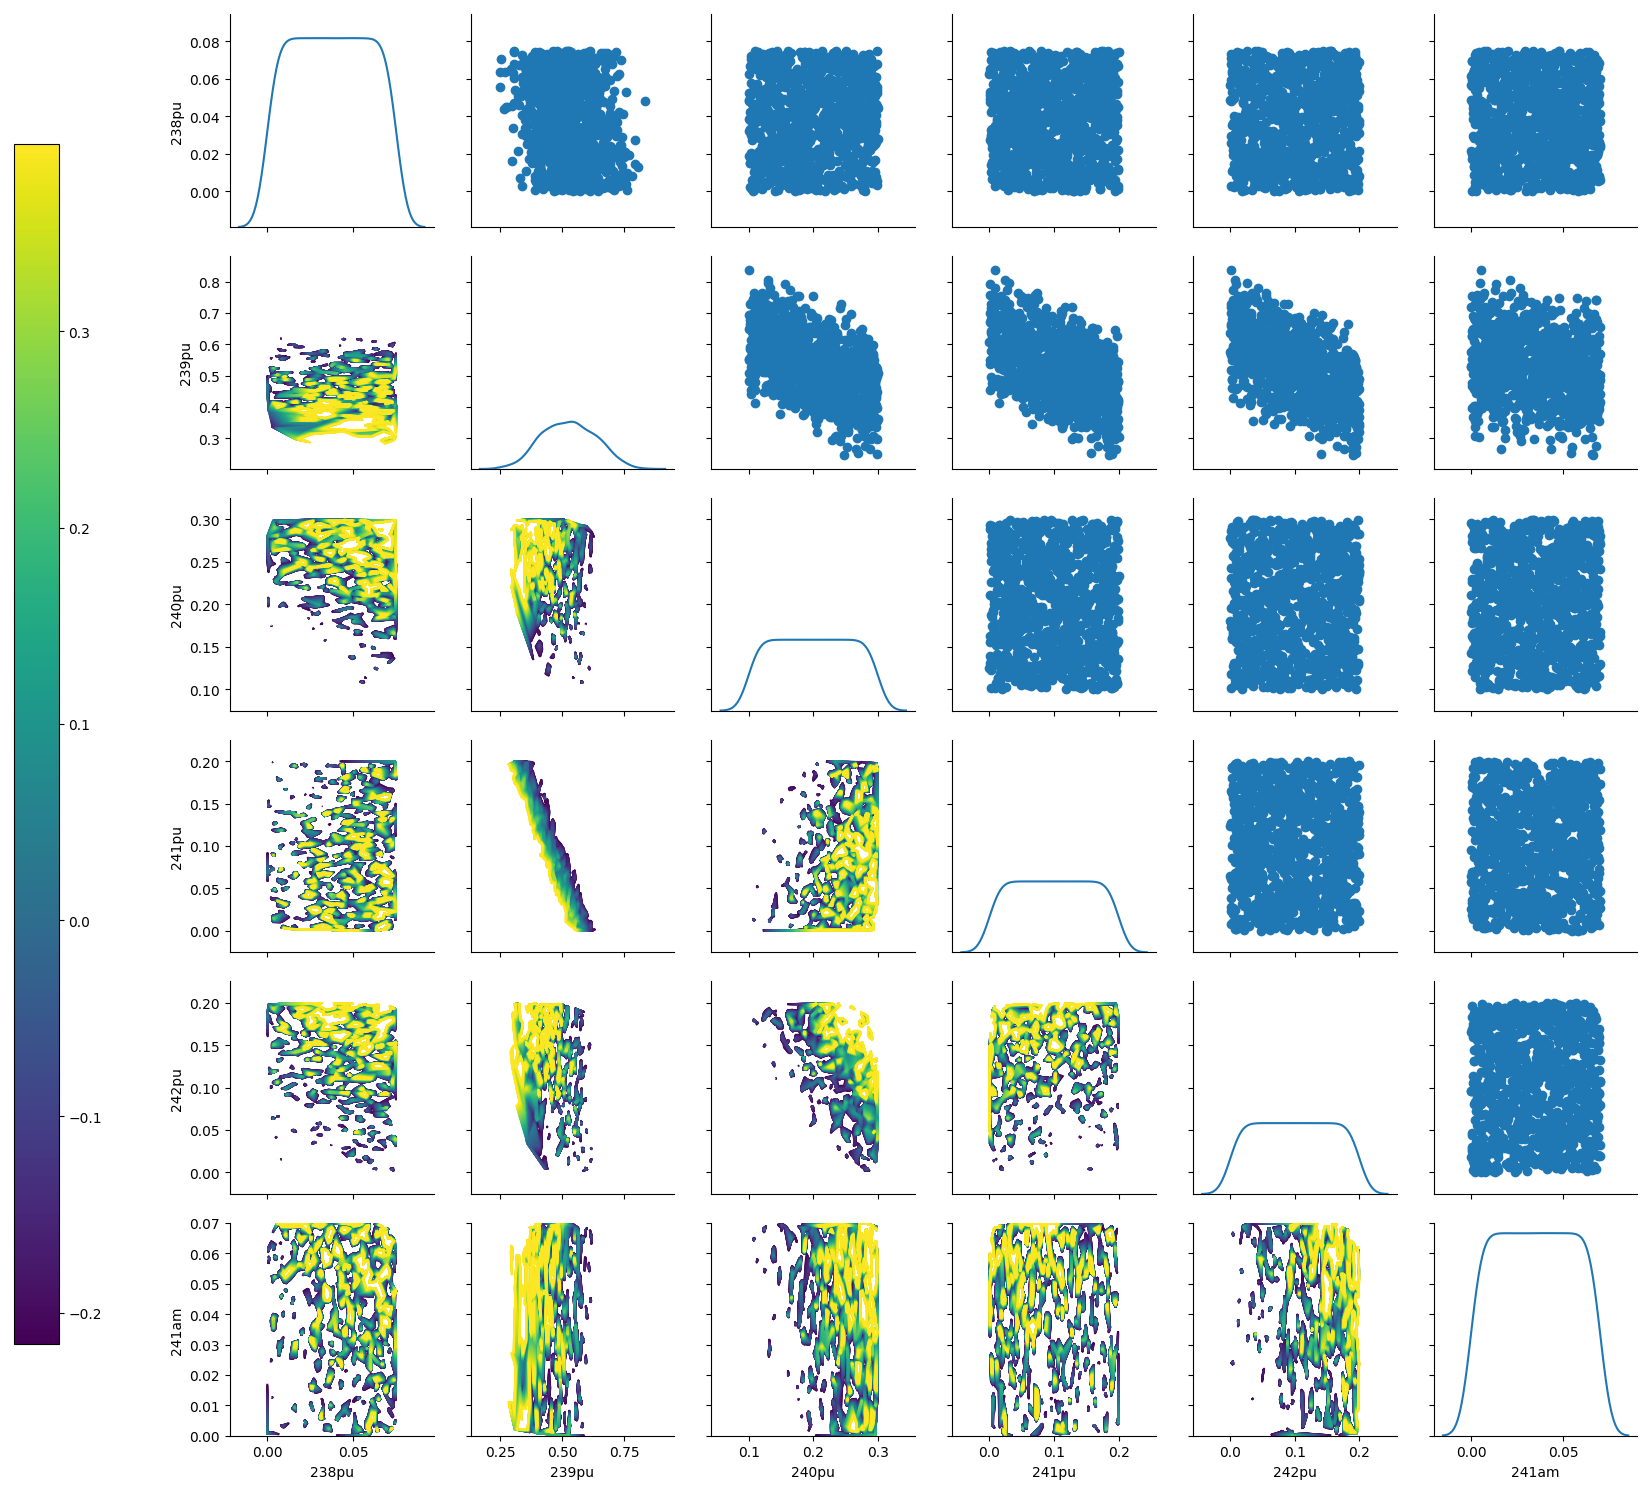

In [33]:
df_frac = df['obs3']
plot(df, "obs3.png", nuc_list_in)

In [49]:
def plot_quiver(df_, df1, filename,name_matrix):
    plt.figure(figsize=(120,120))
    f, axn = plt.subplots(len(name_matrix),len(name_matrix), sharex='col',
            sharey='row')
    i = 0

    for ax_ in axn.flat:
        n_row = i // (len(name_matrix))
        n_col = i % (len(name_matrix))
        i= i+1
        list_ = [0, 1, 2]
        if n_row < n_col:
            not_row_col = np.delete(list_, np.s_[n_col, n_row] ) 
            y = df_[name_matrix[n_row]]*df_['Frac_BOC']*100
            x = df_[name_matrix[n_col]]*df_['Frac_BOC']*100
            v = (df_["out_"+name_matrix[n_row]])*df_['Frac_EOC']*100-(df_[name_matrix[n_row]])*df_['Frac_BOC']*100
            u = (df_["out_"+name_matrix[n_col]])*df_['Frac_EOC']*100-(df_[name_matrix[n_col]])*df_['Frac_BOC']*100
            #v = (df_["out_"+name_matrix[n_row]])-(df_[name_matrix[n_row]])
            #u = (df_["out_"+name_matrix[n_col]])-(df_[name_matrix[n_col]])
            #v = ((df1["out_"+name_matrix[n_row]])-(df1[name_matrix[n_row]])/(df_["out_"+name_matrix[n_row]])-(df_[name_matrix[n_row]]))
            #u = ((df1["out_"+name_matrix[n_col]])-(df1[name_matrix[n_col]])/(df_["out_"+name_matrix[n_row]])-(df_[name_matrix[n_row]]))



            im = ax_.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=10);
            max_yticks = 4
            yloc = plt.MaxNLocator(max_yticks)
            #ax_.yaxis.set_major_locator(yloc)
            ax_.xaxis.set_major_locator(yloc)
        elif n_row == n_col:
            y = df1[name_matrix[n_row]]*df1['Frac_BOC']*100
            x = df1[name_matrix[n_col]]*df1['Frac_BOC']*100
            left, right = np.nanmin(x)*0.8, np.nanmax(x)*1.2
            bottom, top = np.nanmin(y)*0.8, np.nanmax(y)*1.2
            ax_.set_xlim(left,right);
            ax_.set_ylim(bottom,top);
            width = right - left
            height = top - bottom
            width = right - left
            height = top - bottom
            #p = patches.Rectangle(
            #    (left, bottom), width, height,
            #    fill=False, transform=ax_.transAxes, clip_on=False)
            #ax_.add_patch(p)
            ax_.text(0.5*(left+right),
                    0.5*(bottom+top),
                    name_matrix[n_row],
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=10,
                    color='red')




    plt.locator_params(numticks=4)
    plt.savefig(filename, dpi=1200)



In [50]:
df_fix = pd.DataFrame.from_csv("fix.csv")
df_eq = pd.DataFrame.from_csv("eq.csv")
print(df_fix)

        238pu     239pu     240pu     241pu     242pu     241am  out_238pu  \
0    0.005726  0.521715  0.292817  0.131138  0.013695  0.034909   0.027434   
1    0.028566  0.559127  0.230929  0.068285  0.100144  0.012950   0.035517   
2    0.030147  0.543210  0.184449  0.155692  0.069407  0.017096   0.041881   
3    0.004548  0.563214  0.130511  0.132413  0.118487  0.050828   0.034584   
4    0.037347  0.693098  0.113977  0.029201  0.082391  0.043985   0.057724   
5    0.021114  0.613028  0.189564  0.020918  0.114406  0.040969   0.041335   
6    0.030477  0.339081  0.288200  0.186175  0.131683  0.024384   0.045220   
7    0.029063  0.438808  0.280679  0.072923  0.142228  0.036299   0.046424   
8    0.047138  0.435887  0.213402  0.083479  0.171791  0.048302   0.067501   
9    0.030433  0.371034  0.293640  0.076705  0.189242  0.038947   0.048169   
10   0.002890  0.636804  0.258408  0.009090  0.042912  0.049897   0.029096   
11   0.053583  0.708275  0.169785  0.007785  0.016678  0.043893 

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


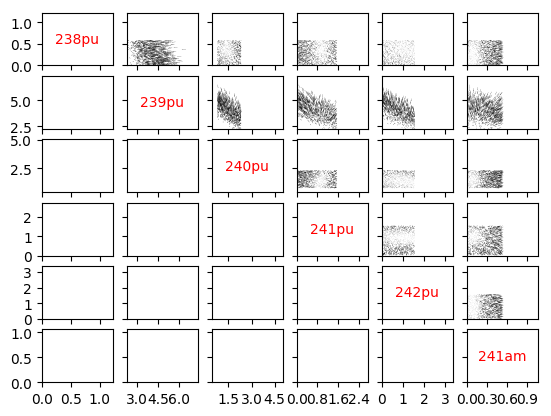

In [51]:
plt.rcParams.update(plt.rcParamsDefault)
df_fix['Frac'] = 1
df_fix['out_Frac'] = 1
plot_quiver(df_fix, df_eq, "Variation_fix.png", nuc_list_in)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


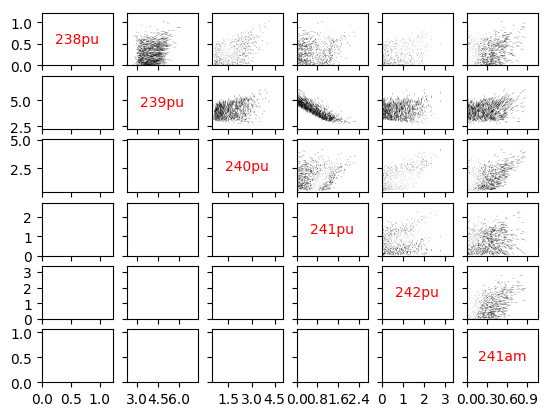

In [52]:
plt.rcParams.update(plt.rcParamsDefault)
df_eq['Frac'] = 1
df_eq['out_Frac'] = 1
plot_quiver(df_eq, df_eq, "Variation_eq.png", nuc_list_in)

In [119]:
SMALL_SIZE = 10
MEDIUM_SIZE = SMALL_SIZE+2
BIGGER_SIZE = MEDIUM_SIZE +2

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
matplotlib.rcParams.update({'font.size': 10})



def plot_quiver_ref(df_, df1, filename,name_matrix):
    plt.figure(figsize=(12,8))
    f, axn = plt.subplots(len(name_matrix),len(name_matrix), sharex='col',
            sharey='row')
    i = 0
        



    for ax_ in axn.flat:
        n_row = i // (len(name_matrix))
        n_col = i % (len(name_matrix))
        i= i+1
        list_ = [0, 1, 2]
        if n_row < n_col:
            not_row_col = np.delete(list_, np.s_[n_col, n_row] ) 
            y = df_[name_matrix[n_row]]
            x = df_[name_matrix[n_col]]
            v = (df1["out_"+name_matrix[n_row]])-(df_["out_"+name_matrix[n_row]])
            u = (df1["out_"+name_matrix[n_col]])-(df_["out_"+name_matrix[n_col]])
            #v = (df_["out_"+name_matrix[n_row]])-(df_[name_matrix[n_row]])
            #u = (df_["out_"+name_matrix[n_col]])-(df_[name_matrix[n_col]])
            #v = ((df1["out_"+name_matrix[n_row]])-(df1[name_matrix[n_row]])/(df_["out_"+name_matrix[n_row]])-(df_[name_matrix[n_row]]))
            #u = ((df1["out_"+name_matrix[n_col]])-(df1[name_matrix[n_col]])/(df_["out_"+name_matrix[n_row]])-(df_[name_matrix[n_row]]))


            im = ax_.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1);
            max_yticks = 4
            yloc = plt.MaxNLocator(max_yticks)
            #ax_.yaxis.set_major_locator(yloc)
            ax_.xaxis.set_major_locator(yloc)
            plt.xlabel('', fontsize=10)



        elif n_row == n_col:
            y = df1[name_matrix[n_row]]
            x = df1[name_matrix[n_col]]
            left, right = np.nanmin(x)*0.8, np.nanmax(x)*1.2
            bottom, top = np.nanmin(y)*0.8, np.nanmax(y)*1.2
            ax_.set_xlim(left,right);
            ax_.set_ylim(bottom,top);
            width = right - left
            height = top - bottom
            width = right - left
            height = top - bottom
            #p = patches.Rectangle(
            #    (left, bottom), width, height,
            #    fill=False, transform=ax_.transAxes, clip_on=False)
            #ax_.add_patch(p)
            ax_.text(0.5*(left+right),
                    0.5*(bottom+top),
                    name_matrix[n_row],
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=10,
                    color='red')
        for item in ([ax_.title, ax_.xaxis.label, ax_.yaxis.label] + ax_.get_xticklabels() + ax_.get_yticklabels()):
            item.set_fontsize(5)
    plt.locator_params(numticks=4)
    plt.savefig(filename, dpi=1200)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:31: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


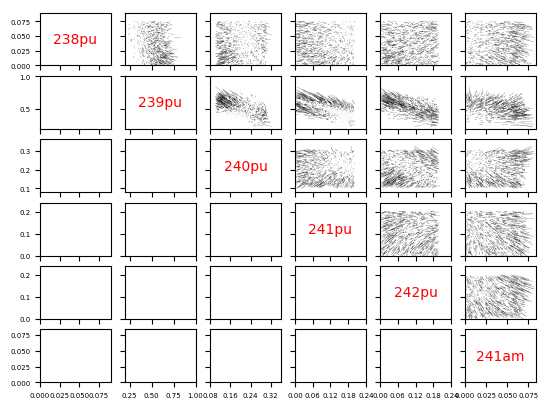

In [120]:
plt.rcParams.update(plt.rcParamsDefault)
df_fix['Frac'] = 1
df_fix['out_Frac'] = 1
plot_quiver_ref(df_fix, df_eq, "Variation_pu_eoc.png", nuc_list_in)

In [73]:
pu = 'out_238pu'
((df_eq[pu]-df_fix[pu])/df_fix[pu]).max()

0.2433072293006083

In [44]:
pu = 'out_239pu'
((df_eq[pu]-df_fix[pu])/df_fix[pu]).max()

0.10434508698163789

In [45]:
pu = 'out_240pu'
((df_eq[pu]-df_fix[pu])/df_fix[pu]).max()

0.150450120776117

In [46]:
pu = 'out_241pu'
((df_eq[pu]-df_fix[pu])/df_fix[pu]).max()

0.24960871994253045

In [47]:
pu = 'out_242pu'
((df_eq[pu]-df_fix[pu])/df_fix[pu]).max()

0.8489766151185054

In [48]:
pu = 'out_241am'
((df_eq[pu]-df_fix[pu])/df_fix[pu]).max()

0.5838830235576609